In [85]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import xesmf
sys.path.append("/home/149/ab8992/tasman-tides/")
import dask
from dask.distributed import Client,default_client
import ttidelib as tt
def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

<Client: 'tcp://127.0.0.1:34553' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34553,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: 1 hour ago,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34705,Total threads: 4
Dashboard: /proxy/44229/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36907,


# Load the input and topog from an existing experiment. Flatten the topography along the beam path

In [69]:
resolution = 20
expt = f'flat-{resolution}'
inputdir = Path(f'/g/data/nm03/ab8992/ttide-inputs')

OgTopog = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'topog.nc'),chunks = "auto")
OgTracers = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'forcing/init_tracers.nc'),chunks = "auto")
OgTracers = OgTracers.ffill("yh").bfill("yh")

# Save the IC tracers with nans removed 
# OgTracers.to_netcdf(str(inputdir / f'full-{resolution}' / 'forcing/init_tracers_filled.nc'),"w")
# Don't need to do tracers since nans are already zeroed

# Get the hgrid and the transect of topo
hgrid = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'hgrid.nc'),chunks = "auto")
BathyTransect = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/bathy_transect.nc",chunks = "auto")



## Make a smoothing function that transitions between 0 and 1 towards the edges of the rectangle

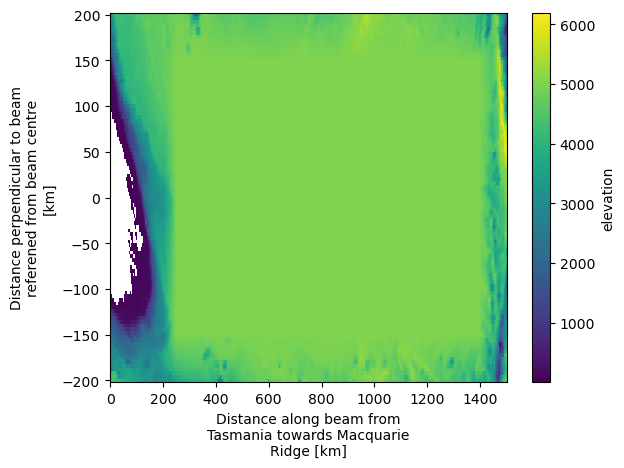

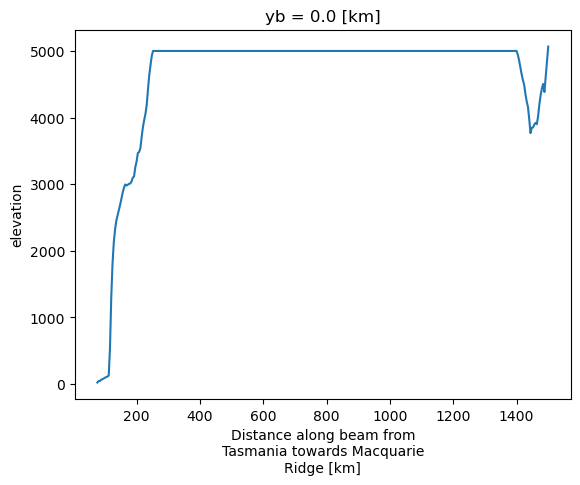

In [112]:
buffer = 50 # buffer in km
xmin,xmax,ymin,ymax = 200,1450,-200,200

smoothing = BathyTransect.elevation * 0 + 1
smoothing = smoothing.where(~((smoothing.xb >= xmin) & (smoothing.xb <= xmax) & (smoothing.yb >= ymin) & (smoothing.yb <= ymax)), 0)

#Western edge
smoothing = smoothing.where(
    ~((smoothing.xb <= xmin + buffer) & (smoothing.xb >= xmin) & (smoothing.yb >= ymin) & (smoothing.yb <= ymax)),
     (buffer - (smoothing.xb - xmin))/buffer)


#Eastern edge
smoothing = smoothing.where(
    ~((smoothing.xb >= xmax - buffer) & (smoothing.xb <= xmax) & (smoothing.yb >= ymin) & (smoothing.yb <= ymax)),
     (buffer - (xmax - smoothing.xb))/buffer)

#Northern edge
# Do the corners
smoothing = smoothing.where(
    ~((smoothing.yb >= ymax - buffer) & (smoothing.yb <= ymax) & (smoothing.xb >= xmin) & (smoothing.xb <= xmax) & (smoothing != 0)),
     (buffer - (ymax - smoothing.yb))/buffer + smoothing)

# Do the rest
smoothing = smoothing.where(
    ~((smoothing.yb >= ymax - buffer) & (smoothing.yb <= ymax) & (smoothing.xb >= xmin + buffer) & (smoothing.xb <= xmax - buffer)),
     (buffer - (ymax - smoothing.yb))/buffer)



# Southern edge

# Do the corners
smoothing = smoothing.where(
    ~((smoothing.yb <= ymin + buffer) & (smoothing.yb >= ymin) & (smoothing.xb >= xmin) & (smoothing.xb <= xmax) & (smoothing != 0)),
     (buffer - (smoothing.yb - ymin))/buffer + smoothing)

# Do the rest
smoothing = smoothing.where(
    ~((smoothing.yb <= ymin + buffer) & (smoothing.yb >= ymin) & (smoothing.xb >= xmin + buffer) & (smoothing.xb <= xmax - buffer)),
     (buffer - (smoothing.yb - ymin))/buffer)

# NE 

smoothing = smoothing.where(smoothing < 1,1)
_smoothing = -1 * (smoothing - 1)


# BathyTransect.elevation.plot(x = "xb",y = "yb",vmax = 0)
flatbottom = -1 * (-5000 * _smoothing + BathyTransect.elevation * smoothing)


# Mask flatbotoom
flatbottom = flatbottom.where(flatbottom > 0,OgTopog.depth[0,-1,0].values)

plt.figure()
flatbottom.plot()



plt.figure()
flatbottom.sel(yb = 0).plot()

## Now re interpolate the bathy onto the original grid and combine the two

In [115]:
OgTopog = OgTopog.assign_coords({
    "lat":(["ny"],hgrid.y.isel(nxp = 0)[1::2].values),
    "lon":(["nx"],hgrid.x.isel(nyp = 0)[1::2].values)
})
basegrid = OgTopog.depth.isel(ntiles = 0) * 0 # Construct grid to interpolate the flattened topo back onto


regridder = xesmf.Regridder(
    flatbottom,basegrid,"bilinear"
)

FullFlattened = regridder(
    flatbottom,keep_attrs = True
    )

FullFlattened

FullFlattened.plot()

plt.figure()
OgTopog.depth[0,:,:].plot()

OgTopogCutout = OgTopog.depth[0,:,:].where(FullFlattened == FullFlattened[0,0],0)


plt.figure()
(OgTopogCutout + FullFlattened).plot()


<xarray.DataArray 'elevation' (ny: 795, nx: 760)>
dask.array<sum-aggregate, shape=(795, 760), dtype=float64, chunksize=(101, 376), chunktype=numpy.ndarray>
Coordinates:
    zi       float64 ...
    lat      (ny) float64 -55.98 -55.94 -55.91 -55.87 ... -26.09 -26.06 -26.02
    lon      (nx) float64 142.0 142.1 142.1 142.2 ... 179.8 179.9 179.9 180.0
Dimensions without coordinates: ny, nx
Attributes:
    regrid_method:  bilinear

# Save to topog_flattened.nc in same folder

In [119]:
OgTopog.depth[0,:,:] = (OgTopogCutout + FullFlattened)
OgTopog.to_netcdf(str(inputdir / f'full-{resolution}' / 'topog_flattened.nc'))
